# Linear Regression
with extra varaibles and split data sets

In [16]:
# import libraries
import pandas as pd

import sys
sys.path.append('../0_DataPreparation')
from utils import plot_missing_heatmap

# import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error


In [17]:
# read train and validation data frame from ../data/processed

df_train_clean = pd.read_csv("../data/processed/df_train_data_cleaned.csv")
df_validation_clean = pd.read_csv("../data/processed/df_validation_data_cleaned.csv")
df_test_clean = pd.read_csv("../data/processed/df_test_data_cleaned.csv")

# convert Datum column to datetime
df_train_clean['Datum'] = pd.to_datetime(df_train_clean['Datum'])
df_validation_clean['Datum'] = pd.to_datetime(df_validation_clean['Datum'])
df_test_clean['Datum'] = pd.to_datetime(df_test_clean['Datum'])


# add month to train
df_train_clean['month'] = df_train_clean['Datum'].dt.month
# add month to validation
df_validation_clean['month'] = df_validation_clean['Datum'].dt.month
# add month to test
df_test_clean['month']= df_test_clean['Datum'].dt.month

# print shape of the datasets
print(f"Train data shape: {df_train_clean.shape}")
print(f"Validation data shape: {df_validation_clean.shape}")
print(f"Test data shape: {df_test_clean.shape}")

if 'experiment_results_LR' not in globals():
    experiment_results_LR = pd.DataFrame(columns=['R2_Train', 'R2_Validation', 'MAPE_Validation','selected_columns'])

if 'experiment_results_PR' not in globals():
    experiment_results_PR = pd.DataFrame(columns=['R2_Train', 'R2_Validation', 'MAPE_Validation','selected_columns'])

# add another column to df_train_clean called last_day_of_year which is 1 if the date is the last day of the year, else 0
df_train_clean['last_day_of_year'] = df_train_clean['Datum'].dt.is_year_end.astype(int)
df_validation_clean['last_day_of_year'] = df_validation_clean['Datum'].dt.is_year_end.astype(int)

# add another column to df_train_clean called last_day_of_year_w5 which is 1 if Warengruppe_umsatz == 5.0 and last_day_of_year == 1, else 0
df_train_clean['last_day_of_year_w5'] = ((df_train_clean['Warengruppe_umsatz'] == 5.0) & (df_train_clean['last_day_of_year'] == 1)).astype(int)
df_validation_clean['last_day_of_year_w5'] = ((df_validation_clean['Warengruppe_umsatz'] == 5.0) & (df_validation_clean['last_day_of_year'] == 1)).astype(int)

Train data shape: (7487, 18)
Validation data shape: (1841, 18)
Test data shape: (1830, 17)


### Dropping extra variables

In [18]:
# ignore some columns
drop_columns = ['Datum', 'umsatz_rolling7','temperature_2m_mean','sunshine_duration','is_saturday','is_sunday']

# drop columns if present
drop_columns = [col for col in drop_columns if col in df_train_clean.columns]

# drop columns from train and validation datasets
df_train_clean = df_train_clean.drop(columns=drop_columns)
df_validation_clean = df_validation_clean.drop(columns=drop_columns)


### Selected Variables

In [19]:
selected_columns = ['Umsatz_umsatz', 'Warengruppe_umsatz', 'day_of_week', 'Temperatur_weather', 'month', 'KielerWoche_kiwo','last_day_of_year']
df_train_clean = df_train_clean[selected_columns]
df_validation_clean = df_validation_clean[selected_columns]

### Categorial_cols

In [20]:
categorical_cols = ['Warengruppe_umsatz', 'day_of_week','month','Bewoelkung_weather','school_holiday','KielerWoche_kiwo','public_holiday','next_day_holiday','last_day_of_year','last_day_of_year_w5'] 
# filter to only those present in the data
categorical_cols = [col for col in categorical_cols if col in df_train_clean.columns]

df_train_clean_cat = pd.get_dummies(df_train_clean, columns=categorical_cols, drop_first=False) 
df_validation_clean_cat = pd.get_dummies(df_validation_clean, columns=categorical_cols, drop_first=False)

# ensure train and validation have the same columns (in case of missing categories in validation)
df_validation_clean_cat = df_validation_clean_cat.reindex(columns=df_train_clean_cat.columns, fill_value=0)

In [21]:
correlations_with_target = df_train_clean_cat.corr()['Umsatz_umsatz'].sort_values(ascending=False)
print(correlations_with_target)

Umsatz_umsatz             1.000000
Warengruppe_umsatz_2.0    0.670450
Warengruppe_umsatz_5.0    0.238443
Temperatur_weather        0.216569
month_8                   0.173527
last_day_of_year_1        0.139786
month_7                   0.134890
day_of_week_6             0.109829
day_of_week_5             0.097841
KielerWoche_kiwo_1.0      0.053631
month_6                   0.034507
month_9                   0.012460
month_10                  0.006555
month_5                   0.006138
month_4                  -0.012115
day_of_week_4            -0.027166
day_of_week_3            -0.036607
month_2                  -0.036918
day_of_week_0            -0.037176
day_of_week_2            -0.050720
KielerWoche_kiwo_0.0     -0.053631
month_3                  -0.054998
day_of_week_1            -0.055598
month_12                 -0.078531
month_1                  -0.078603
month_11                 -0.109976
last_day_of_year_0       -0.139786
Warengruppe_umsatz_3.0   -0.150665
Warengruppe_umsatz_6

In [22]:

# prepare features and target
# assuming 'Umsatz' is the target column
target = 'Umsatz_umsatz'
X_train = df_train_clean_cat.drop(columns=[target])
y_train = df_train_clean_cat[target]
X_validation = df_validation_clean_cat.drop(columns=[target])
y_validation = df_validation_clean_cat[target]

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)


# print learned equation
print("Learned equation:")
equation = f"y = {model.intercept_:.4f}"
for feature, coef in zip(X_train.columns, model.coef_):
    equation += f" + ({coef:.4f}) * {feature}"
print(equation)

# calculate R2 on train and validation
y_train_pred = model.predict(X_train)
y_validation_pred = model.predict(X_validation)

r2_train = r2_score(y_train, y_train_pred)
r2_validation = r2_score(y_validation, y_validation_pred)

print(f"R2 on train: {r2_train}")
print(f"R2 on validation: {r2_validation}")

# calculate MAPE on validation
mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)
print(f"MAPE on validation: {mape_validation}")

# concat results in experiment_results_LR
experiment_results_LR = pd.concat([experiment_results_LR, pd.DataFrame({'R2_Train': [r2_train], 'R2_Validation': [r2_validation], 'MAPE_Validation': [mape_validation],'selected_columns':[selected_columns]})], ignore_index=True)
display(experiment_results_LR.tail(5))

Learned equation:
y = 421.3186 + (0.7205) * Temperatur_weather + (-73.1170) * Warengruppe_umsatz_1.0 + (216.0469) * Warengruppe_umsatz_2.0 + (-30.3607) * Warengruppe_umsatz_3.0 + (-105.3434) * Warengruppe_umsatz_4.0 + (86.4065) * Warengruppe_umsatz_5.0 + (-93.6324) * Warengruppe_umsatz_6.0 + (-11.6420) * day_of_week_0 + (-19.2093) * day_of_week_1 + (-19.8060) * day_of_week_2 + (-13.6502) * day_of_week_3 + (-9.9411) * day_of_week_4 + (32.7837) * day_of_week_5 + (41.4648) * day_of_week_6 + (-31.8181) * month_1 + (-13.9728) * month_2 + (-24.9758) * month_3 + (-6.7194) * month_4 + (-0.5711) * month_5 + (1.4021) * month_6 + (51.0227) * month_7 + (79.5474) * month_8 + (1.6904) * month_9 + (4.5668) * month_10 + (-31.4164) * month_11 + (-28.7560) * month_12 + (-17.3240) * KielerWoche_kiwo_0.0 + (17.3240) * KielerWoche_kiwo_1.0 + (-221.6827) * last_day_of_year_0 + (221.6827) * last_day_of_year_1
R2 on train: 0.7574540369728897
R2 on validation: 0.7257662239386755
MAPE on validation: 0.327146475

,R2_Train,R2_Validation,MAPE_Validation,selected_columns
0,0.757454,0.725766,0.327146,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."
1,0.757454,0.725766,0.327146,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."


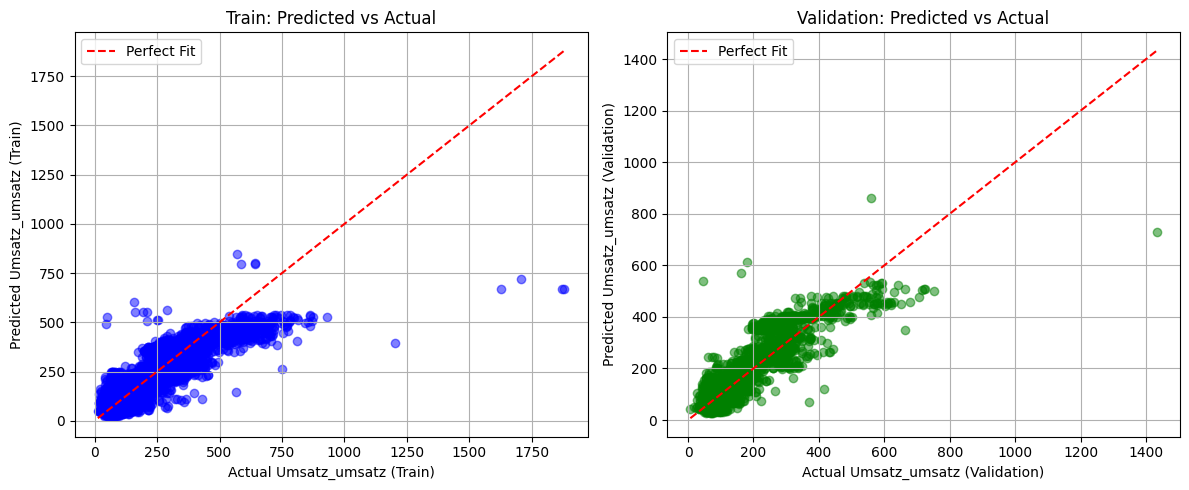

In [23]:
# plot the equation
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# train plot
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Fit')
axes[0].set_xlabel('Actual Umsatz_umsatz (Train)')
axes[0].set_ylabel('Predicted Umsatz_umsatz (Train)')
axes[0].set_title('Train: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True)

# validation plot
axes[1].scatter(y_validation, y_validation_pred, alpha=0.5, color='green')
axes[1].plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label='Perfect Fit')
axes[1].set_xlabel('Actual Umsatz_umsatz (Validation)')
axes[1].set_ylabel('Predicted Umsatz_umsatz (Validation)')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## PolynomialFeature
Captures Non-Linearity: If features like temperature or holidays have quadratic effects on sales, polynomial terms (e.g., x²) fit curves.
- Simple Extension: Still uses LinearRegression, but on transformed features.
- Risks: Higher degrees increase complexity/overfitting; monitor validation R².

Learned equation for polynomial regression:
y = 326.0330 + (1.6914) * Temperatur_weather + (-57.0780) * Warengruppe_umsatz_1.0 + (55.8072) * Warengruppe_umsatz_2.0 + (-54.0420) * Warengruppe_umsatz_3.0 + (-80.0644) * Warengruppe_umsatz_4.0 + (217.5091) * Warengruppe_umsatz_5.0 + (-82.1319) * Warengruppe_umsatz_6.0 + (-4.8944) * day_of_week_0 + (-15.3170) * day_of_week_1 + (-1.9948) * day_of_week_2 + (14.1483) * day_of_week_3 + (-1.5486) * day_of_week_4 + (4.4471) * day_of_week_5 + (5.1594) * day_of_week_6 + (-10.8025) * month_1 + (-5.7900) * month_2 + (-11.0592) * month_3 + (-4.2702) * month_4 + (13.2969) * month_5 + (4.7269) * month_6 + (3.4580) * month_7 + (37.0724) * month_8 + (0.3982) * month_9 + (-17.1659) * month_10 + (-9.5010) * month_11 + (-0.3635) * month_12 + (-10.8683) * KielerWoche_kiwo_0.0 + (10.8683) * KielerWoche_kiwo_1.0 + (-29.2017) * last_day_of_year_0 + (29.2017) * last_day_of_year_1 + (0.0544) * Temperatur_weather^2 + (-0.1607) * Temperatur_weather Warengruppe_umsat

,R2_Train,R2_Validation,MAPE_Validation,selected_columns
0,0.894505,0.849503,0.226116,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."
1,0.894505,0.849503,0.226116,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."


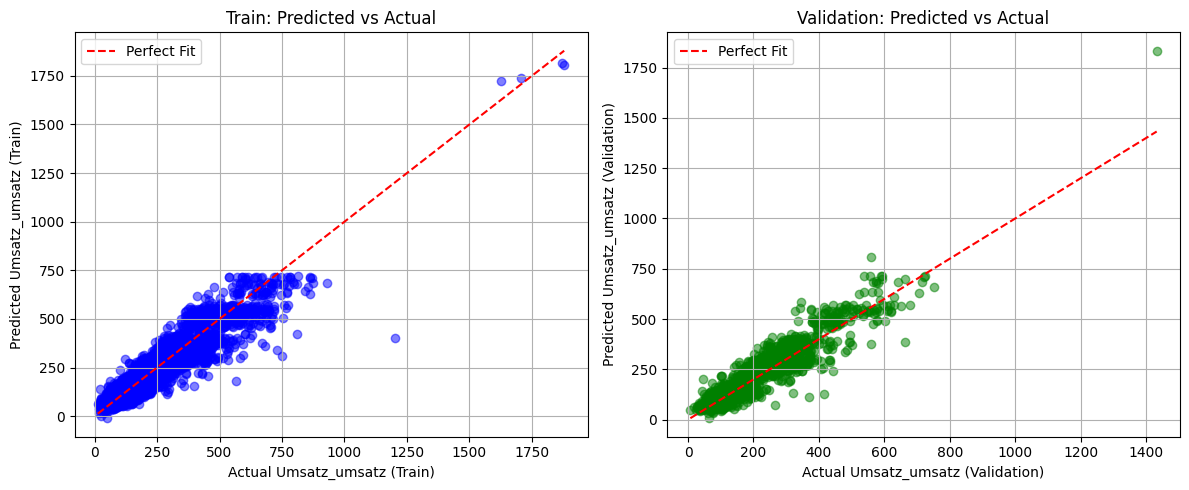

In [24]:
# ...existing code...

from sklearn.preprocessing import PolynomialFeatures

# prepare features and target
target = 'Umsatz_umsatz'
X_train = df_train_clean_cat.drop(columns=[target])
y_train = df_train_clean_cat[target]
X_validation = df_validation_clean_cat.drop(columns=[target])
y_validation = df_validation_clean_cat[target]

# add polynomial features (degree 2 for quadratic)
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_validation_poly = poly.transform(X_validation)

# fit polynomial regression (still LinearRegression on transformed features)
model = LinearRegression()
model.fit(X_train_poly, y_train)

print("Learned equation for polynomial regression:")
equation = f"y = {model.intercept_:.4f}"
feature_names = poly.get_feature_names_out(X_train.columns)
for feature, coef in zip(feature_names, model.coef_):
    equation += f" + ({coef:.4f}) * {feature}"
print(equation)

# predict
y_train_pred = model.predict(X_train_poly)
y_validation_pred = model.predict(X_validation_poly)

# evaluate
r2_train = r2_score(y_train, y_train_pred)
r2_validation = r2_score(y_validation, y_validation_pred)
mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)

print(f"R2 on train: {r2_train:.4f}")
print(f"R2 on validation: {r2_validation:.4f}")
print(f"MAPE on validation: {mape_validation:.4f}")

# concat results in experiment_results_PR
experiment_results_PR = pd.concat([experiment_results_PR, pd.DataFrame({'R2_Train': [r2_train], 'R2_Validation': [r2_validation], 'MAPE_Validation': [mape_validation],'selected_columns':[selected_columns]})], ignore_index=True)
display(experiment_results_PR.tail(5))

# plot predicted vs actual (same as before)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Fit')
axes[0].set_xlabel('Actual Umsatz_umsatz (Train)')
axes[0].set_ylabel('Predicted Umsatz_umsatz (Train)')
axes[0].set_title('Train: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(y_validation, y_validation_pred, alpha=0.5, color='green')
axes[1].plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label='Perfect Fit')
axes[1].set_xlabel('Actual Umsatz_umsatz (Validation)')
axes[1].set_ylabel('Predicted Umsatz_umsatz (Validation)')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ...existing code...

## Combined Dataset Training
Combining all the dataset

In [25]:
# merge df_train_clean and df_validation_clean and create df_combined
df_combined = pd.concat([df_train_clean, df_validation_clean], ignore_index=True)
df_combined.head()

,Umsatz_umsatz,Warengruppe_umsatz,day_of_week,Temperatur_weather,month,KielerWoche_kiwo,last_day_of_year
0,148.828353,1.0,0,17.8375,7,0.0,0
1,535.856285,2.0,0,17.8375,7,0.0,0
2,201.198426,3.0,0,17.8375,7,0.0,0
3,65.890169,4.0,0,17.8375,7,0.0,0
4,317.475875,5.0,0,17.8375,7,0.0,0


In [26]:
# pring na values of df_combined
print(df_combined.isna().sum())

Umsatz_umsatz         0
Warengruppe_umsatz    0
day_of_week           0
Temperatur_weather    0
month                 0
KielerWoche_kiwo      0
last_day_of_year      0
dtype: int64


In [27]:
# training on combined dataset for Polynomial Regression using dummified selected + categorical features
# concatenate the dummified train and validation sets to keep consistent one-hot columns
df_combined_cat = pd.concat([df_train_clean_cat, df_validation_clean_cat], ignore_index=True)

# align columns defensively (in case validation lacked some categories earlier)
df_combined_cat = df_combined_cat.reindex(columns=df_train_clean_cat.columns, fill_value=0)
print(f"Combined (dummified) shape: {df_combined_cat.shape}")

# prepare features and target from the dummified combined dataframe
target = 'Umsatz_umsatz'
X_combined = df_combined_cat.drop(columns=[target])
y_combined = df_combined_cat[target]

print("Columns in combined (dummified) features:")
print(X_combined.columns.tolist())

# optional: shuffle combined data to avoid any ordering effects
combined = pd.concat([X_combined, y_combined], axis=1).sample(frac=1, random_state=42).reset_index(drop=True)
X_combined = combined.drop(columns=[target])
y_combined = combined[target]

# polynomial transform and training
poly = PolynomialFeatures(degree=2, include_bias=False)
X_combined_poly = poly.fit_transform(X_combined)

model2 = LinearRegression()
model2.fit(X_combined_poly, y_combined)

print("Learned equation for polynomial regression on combined (dummified) dataset:")
equation = f"y = {model2.intercept_:.4f}"
feature_names = poly.get_feature_names_out(X_combined.columns)
for feature, coef in zip(feature_names, model2.coef_):
    equation += f" + ({coef:.4f}) * {feature}"
print(equation)

# evaluate
y_combined_pred = model2.predict(X_combined_poly)
r2_combined = r2_score(y_combined, y_combined_pred)
print(f"R2 on combined dataset: {r2_combined:.4f}")
# calculate MAPE on combined dataset
mape_combined = mean_absolute_percentage_error(y_combined, y_combined_pred)
print(f"MAPE on combined dataset: {mape_combined:.4f}")



Combined (dummified) shape: (9328, 31)
Columns in combined (dummified) features:
['Temperatur_weather', 'Warengruppe_umsatz_1.0', 'Warengruppe_umsatz_2.0', 'Warengruppe_umsatz_3.0', 'Warengruppe_umsatz_4.0', 'Warengruppe_umsatz_5.0', 'Warengruppe_umsatz_6.0', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'KielerWoche_kiwo_0.0', 'KielerWoche_kiwo_1.0', 'last_day_of_year_0', 'last_day_of_year_1']
Learned equation for polynomial regression on combined (dummified) dataset:
y = 345.7497 + (-2.0981) * Temperatur_weather + (-52.6216) * Warengruppe_umsatz_1.0 + (52.1528) * Warengruppe_umsatz_2.0 + (-51.5299) * Warengruppe_umsatz_3.0 + (-77.9790) * Warengruppe_umsatz_4.0 + (210.7216) * Warengruppe_umsatz_5.0 + (-80.7440) * Warengruppe_umsatz_6.0 + (-2.9500) * day_of_week_0 + (-9.9023) * day

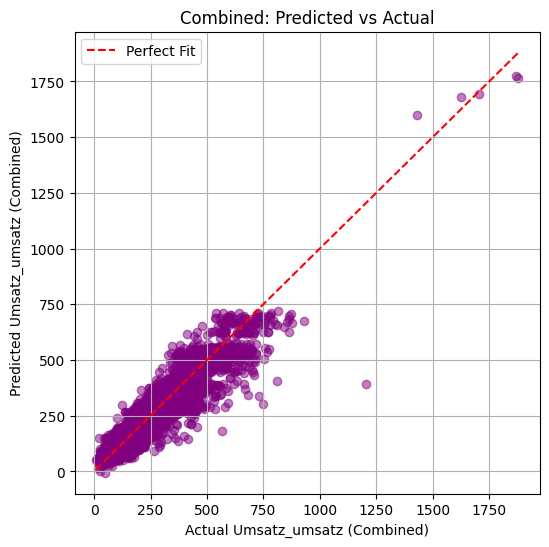

In [28]:
# visualize predicted vs actual for combined dataset
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(y_combined, y_combined_pred, alpha=0.5, color='purple')
plt.plot([y_combined.min(), y_combined.max()], [y_combined.min(), y_combined.max()], 'r--', label='Perfect Fit')
plt.xlabel('Actual Umsatz_umsatz (Combined)')
plt.ylabel('Predicted Umsatz_umsatz (Combined)')
plt.title('Combined: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show() 

In [ ]:
# use model2 to predict values for test dataframe

# Prepare test set using the same selected + categorical preprocessing
# keep only selected columns that are present in the test frame
test_sel_cols = [c for c in selected_columns if c in df_test_clean.columns]
df_test_sel = df_test_clean[test_sel_cols].copy()

# create dummies for categorical columns present in the test set
test_cats = [c for c in categorical_cols if c in df_test_sel.columns]
df_test_cat = pd.get_dummies(df_test_sel, columns=test_cats, drop_first=False)

# align test feature columns with the combined training features (X_combined)
# fill missing columns with 0 so polynomial transform has consistent input
df_test_cat = df_test_cat.reindex(columns=X_combined.columns, fill_value=0)

X_test = df_test_cat

# transform with the polynomial transformer (fitted on combined data)
X_test_poly = poly.transform(X_test)

# predict with model2
y_test_pred = model2.predict(X_test_poly)

# attach predictions to original test dataframe
df_test_clean = df_test_clean.copy()
df_test_clean['predicted_polynomial_combined'] = y_test_pred

print("Predictions added to df_test_clean['predicted_polynomial_combined']")
display(df_test_clean.head())
# print df_test_clean shape and first 5 rows
print(f"df_test_clean shape: {df_test_clean.shape}")

print('No ground-truth `Umsatz_umsatz` in test set — predictions saved to df_test_clean.')

# write predicted values to ../data/processed/polynomial_regression_predicted.csv
#use id and predicted_polynomial_combined columns to write to csv as id and umsatz columns
df_test_clean[['id', 'predicted_polynomial_combined']].rename(columns={'predicted_polynomial_combined': 'umsatz'}).to_csv("../data/processed/polynomial_regression_predicted.csv", index=False)



Predictions added to df_test_clean['predicted_polynomial_combined']


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,id,Warengruppe_umsatz,day_of_week,is_saturday,is_sunday,sunshine_duration,temperature_2m_mean,sunshine_hours,public_holiday,school_holiday,next_day_holiday,month,predicted_polynomial_combined
0,2018-08-01,0.0,0.0,23.7625,10.0,1808011,1.0,2,0,0,50441.36,21.4,14.011489,0.0,1.0,0.0,8,173.365590
1,2018-08-01,0.0,0.0,23.7625,10.0,1808012,2.0,2,0,0,50441.36,21.4,14.011489,0.0,1.0,0.0,8,582.827373
2,2018-08-01,0.0,0.0,23.7625,10.0,1808013,3.0,2,0,0,50441.36,21.4,14.011489,0.0,1.0,0.0,8,271.131740
3,2018-08-01,0.0,0.0,23.7625,10.0,1808014,4.0,2,0,0,50441.36,21.4,14.011489,0.0,1.0,0.0,8,84.480022
4,2018-08-01,0.0,0.0,23.7625,10.0,1808015,5.0,2,0,0,50441.36,21.4,14.011489,0.0,1.0,0.0,8,904.705257


df_test_clean shape: (1830, 18)
No ground-truth `Umsatz_umsatz` in test set — predictions saved to df_test_clean.
